# First Year Project
## Project 4 - Natural Language Processing
### Professor - Christian Hardmeier

This notebook contains all of the code developed for project 4. We will be using a data set of tweets to perform machine learning for binary and multiclass classification.

For **binary** classification, we evaluate tweets based on *'ironic'* or *'not ironic'*. [Learn More](https://www.aclweb.org/anthology/S18-1005.pdf)
<br>
For **multiclass** classification, we evaluate predict which emojis are used based on the text data. [Learn More](https://www.aclweb.org/anthology/S18-1003.pdf)

Group 3:<br>
Crisanna Cornish (ccor@itu.dk)<br>
Danielle Dequin (ddeq@itu.dk)<br>
Gino Franco Fazzi (gifa@itu.dk)<br>
Moneeca Abru Iftikhar Latif (abml@itu.dk)<br>
Carl August Wismer (cwis@itu.dk)

Created: 27-04-2021<br>
Last Modified: 29-05-2021

# Data Source

We use the TweetEval repository, a collection of 7 datasets for different classification tasks based on social media post. The repository can be found here: https://github.com/cardiffnlp/tweeteval.git

Each dataset is presented in the same format and with fixed training, validation and test splits.

# Imports

In [1]:
import re
import sys
import csv
import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.util import ngrams
from nltk.lm import NgramCounter
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE
from nltk.lm import Laplace
from nltk.lm import KneserNeyInterpolated
from nltk.lm import WittenBellInterpolated

import os
import matplotlib.pyplot as plt
from math import log

from sklearn.metrics import classification_report,\
confusion_matrix, accuracy_score, plot_confusion_matrix, recall_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

# Constants

### Paths

In [2]:
# irony text:
IRONY_RAW_PATH = '../datasets/irony/raw/'
IRONY_INTERIM_PATH = '../datasets/irony/interim/'

# emoji:
EMOJI_RAW_PATH = '../datasets/emoji/raw/'
EMOJI_INTERIM_PATH = '../datasets/emoji/interim/'

### Files:

In [3]:
TEST = 'test_text.txt'
TRAIN = 'train_text.txt'
VAL = 'val_text.txt'

TEST_LABELS = 'test_labels.txt'
TRAIN_LABELS = 'train_labels.txt'
VAL_LABELS = 'val_labels.txt'

TEST_INTERIM = 'test_separated.csv'
TRAIN_INTERIM = 'train_separated.csv'
VAL_INTERIM = 'val_separated.csv'

# Functions:

In [4]:
def tokenise(line):
    """A function that takes input and tokenizes the input
    """
    # Initialise lists
    tokens = []
    unmatchable = []

    # Compile patterns for speedup
    token_pat = re.compile(r'\w+|#+|\'|@|\.\.+|!+|\?+')
    skippable_pat = re.compile(r',|\|http://t.co/+')  # typically spaces

    # As long as there's any material left...
    while line:
        # Try finding a skippable token delimiter first.
        skippable_match = re.search(skippable_pat, line)
        if skippable_match and skippable_match.start() == 0:
            # If there is one at the beginning of the line, just skip it.
            line = line[skippable_match.end():]
        else:
            # Else try finding a real token.
            token_match = re.search(token_pat, line)
            if token_match and token_match.start() == 0:
                #print(line[token_match.start():token_match.end()])
                if line[token_match.start():token_match.end()] == '#':
                    # keep hash tags together and seperate
                    try:
                        token_match2 = re.search(token_pat, line[1:])
                        if ' ' in line[token_match2.start():token_match2.end()]:
                            line = line[token_match.end():]
                        else:
                            tokens.append(line[:token_match2.end()+1])
                            line = line[token_match2.end()+1:]
                    except:
                        line = line[token_match.end():]

                elif line[token_match.start():token_match.end()] == '@':
                    # keep @ tags together and seperate
                    try:
                        token_match2 = re.search(token_pat, line[1:])
                        if ' ' in line[token_match2.start():token_match2.end()]:
                            line = line[token_match.end():]
                        
                        else: 
                            tokens.append(line[:token_match2.end()+1])
                            line = line[token_match2.end()+1:]
                    except:
                        line = line[token_match.end():]

                elif line[token_match.start():token_match.end()] == "'":
                    # handle contractions as a single word
                    try:
                        token_match2 = re.search(token_pat, line[1:])
                        if ' ' in line[token_match2.start():token_match2.end()]:
                            line = line[token_match.end():]
                        
                        else: 
                            tokens.append(line[:token_match2.end()+1])
                            line = line[token_match2.end()+1:]
                    except:
                        line = line[token_match.end():]

                # If there is one at the beginning of the line, tokenise it
                else:
                    tokens.append(line[:token_match.end()])
                    line = line[token_match.end():]
            else:
                # Else there is unmatchable material
                # It ends where a skippable or token match starts, or at the end of the line.
                unmatchable_end = len(line)
                if skippable_match:
                    unmatchable_end = skippable_match.start()
                if token_match:
                    unmatchable_end = min(unmatchable_end, token_match.start())
                # Add it to unmatchable and discard from line.
                unmatchable.append(line[:unmatchable_end])
                line = line[unmatchable_end:]

    final_tokens = []

    while len(tokens) > 0:
        temp1 = tokens.pop(0)
        try:
            temp2 = tokens.pop(0)
            if temp2[0] == "'":
                temp1 += temp2
                final_tokens.insert(0, temp1)
            else:
                final_tokens.insert(0, temp1)
                tokens.insert(0, temp2)
        except:
            final_tokens.insert(0, temp1)
        
    final_tokens = final_tokens[::-1]

    return final_tokens

def token_data(data, interim, tokenizer=None):
    """Function to tokenize from raw text file. Takes a reading file path, a writing file path and a
    tokenizer argument (None for default tokenizer, 'Compare' for TweetTokenizer).
    Writes a file with the tokenize lines and returns a list (lines) of lists (tokens).
    """
    if tokenizer == None:
        # Open raw data text and tokenize using our tokenise function
        f = open(data, "r", encoding="utf-8")
        token_list = []
        for line in f:
            token_list.append(tokenise(line))
        f.close()
    
    elif tokenizer == "compare":
        # Use the NLTK TweetTokenizer
        tknzr = TweetTokenizer()

        f = open(data, "r", encoding="utf-8")
        token_list = []
        for line in f:
            token_list.append(tknzr.tokenize(line))
        f.close()
        
    # Write the tokenized data to an interim csv file
    with open(interim, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerows(token_list)
        
    return token_list

def token_counter(tokens, n= 10, inverse=False):
    """Count Tokens. Default setting will output the 10 most common tokens.
    If parameter inverse=True, output the 10 least common tokens.
    """
    plain = [t for l in tokens for t in l]
    counter = Counter(plain)
    if not inverse:
        return counter.most_common(n)
    else:
        return counter.most_common()[:-n-1:-1]

def zipf_law(tokens, ds_name=''):
    """Auxiliary function that takes a collection of tokens and applies Zipf's law formula and
    plots its results. An optional argument will display the name of the DataSet being shown.
    """
    x = [log(x) for x in range(1, len(tokens)+1)]
    y = []

    ordered = token_counter(tokens, n=len(tokens))

    for tup in ordered:
        word, count = tup
        y.append(log(count))
    
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.set_xlabel('Log(Rank)')
    ax.set_ylabel('Log(Freq)')
    ax.set_title(f'Zipf Law for {ds_name} dataset')

# Load data: Task 1

## Load Irony Training Data

In [5]:
# Open Irony Training data set, tokenize, and write to a csv file
irony = token_data(IRONY_RAW_PATH + TRAIN, IRONY_INTERIM_PATH+TRAIN_INTERIM)

In [6]:
irony[0] # A taste of the tokens

['seeing',
 'ppl',
 'walking',
 'w',
 'crutches',
 'makes',
 'me',
 'really',
 'excited',
 'for',
 'the',
 'next',
 '3',
 'weeks',
 'of',
 'my',
 'life']

## Load Emoji Training Data

In [7]:
# Open Emoji raw training data, tokenize, and write to an interim csv file
emoji = token_data(EMOJI_RAW_PATH + TRAIN, EMOJI_INTERIM_PATH+TRAIN_INTERIM)

In [8]:
emoji[2] # A test of emojis

['Love',
 'love',
 'love',
 'all',
 'these',
 'people',
 '#friends',
 '#bff',
 '#celebrate',
 '#blessed',
 '#sundayfunday',
 'San']

## Compare Tokeniser Output 
With the baseline tokenisation from the socialmedia tokeniser in the NLTK library (nltk.tokenize.TweetTokenizer)

In [9]:
# Open emoji training data, tokenize with NLTK tokenizer, write to interim csv for comparison
compare_emoji = token_data(EMOJI_RAW_PATH + TRAIN, EMOJI_INTERIM_PATH+'train_separated_compared.csv',"compare")

In [10]:
print(compare_emoji[3])
print(emoji[3])

['️', '️', '️', '️', '@', 'Toys', '"', 'R', '"', 'Us']
['Toys', 'R', 'Us']


In [11]:
# Open irony training data, tokenize with NLTK tokenizer, write to interim csv for comparison
compare_irony = token_data(IRONY_RAW_PATH + TRAIN, IRONY_INTERIM_PATH+'train_separated_compared.csv',"compare")

In [12]:
print(compare_irony[3])
print(irony[3])

['@user', '@user', 'So', 'is', 'he', 'banded', 'from', 'wearing', 'the', 'clothes', '?', '#Karma']
['@user', '@user', 'So', 'is', 'he', 'banded', 'from', 'wearing', 'the', 'clothes', '?', '#Karma']


# Characterize Data: Task 2

In [13]:
# Create Irony Training Dataframe
temp1 = pd.read_csv(IRONY_INTERIM_PATH+TRAIN_INTERIM, delimiter="\n", names=['tweet'])
temp2 = pd.read_csv(IRONY_RAW_PATH+TRAIN_LABELS, names=['label'])
irony_train_df = temp1.merge(temp2, left_index=True, right_index=True)

# Load Irony Validation Data
irony_val = token_data(IRONY_RAW_PATH + VAL, IRONY_INTERIM_PATH + VAL_INTERIM)

# Create Irony Validation Dataframe
temp1 = pd.read_csv(IRONY_INTERIM_PATH+VAL_INTERIM, delimiter="\n", names=['tweet'])
temp2 = pd.read_csv(IRONY_RAW_PATH+VAL_LABELS, names=['label'])
irony_val_df = temp1.merge(temp2, left_index=True, right_index=True)

## Irony Data

### Number of Tweets

In [14]:
print(f"There are {irony_train_df.shape[0]} tweets in the Irony data set")
print(f'Ironic: {irony_train_df.label.value_counts()[1]}\nNon-ironic: {irony_train_df.label.value_counts()[0]}')

There are 2862 tweets in the Irony data set
Ironic: 1445
Non-ironic: 1417


### Most common Tokens

In [15]:
token_counter(irony)

[('@user', 1731),
 ('the', 964),
 ('to', 934),
 ('a', 757),
 ('I', 724),
 ('is', 483),
 ('and', 470),
 ('!', 464),
 ('in', 440),
 ('of', 426)]

### Least Common Tokens

In [16]:
token_counter(irony, inverse=True)

[('dues', 1),
 ('shorted', 1),
 ('union', 1),
 ('#skincare', 1),
 ('heaven', 1),
 ('products', 1),
 ('thot', 1),
 ('#practicewhatyoupreach', 1),
 ('cracks', 1),
 ('managers', 1)]

In [17]:
irony_tokens = [t for l in irony for t in l] # Get tokens for each line of the irony data set
irony_one_timers = []
irony_mult_timers = []

for tup in token_counter(irony, n=len(irony_tokens)):
    k, v = tup # Unpack
    if v == 1:
        irony_one_timers.append(k)
    else:
        irony_mult_timers.append(k)

In [18]:
print(f'Number of words that occur only once:\
{len(irony_one_timers)} ({len(irony_one_timers)/(len(irony_one_timers)+len(irony_mult_timers)):.0%})\n\
Number of words that occur more than once:\
{len(irony_mult_timers)} ({len(irony_mult_timers)/(len(irony_one_timers)+len(irony_mult_timers)):.0%})\n\
Total word count, including repeated words: {len(irony_tokens)}')

Number of words that occur only once:7250 (70%)
Number of words that occur more than once:3050 (30%)
Total word count, including repeated words: 40371


### Check Zipf's Law

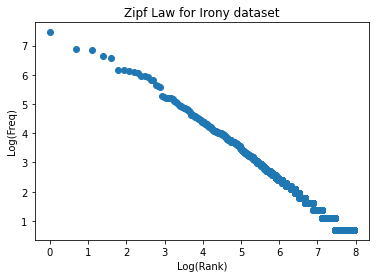

In [19]:
zipf_law(irony, 'Irony');
#plt.savefig('../reports/figures/zipf_law_irony.png')

By simple visual inspection, the graph seems to be consistent with the empirical Zipf Law (a semi-straight line crosses the plot).

$$\frac{Type}{Token} ratio$$

Ratio of number of types (vocabulary size) to number of tokens
(text/corpus size).

In [ ]:
len(token_counter(irony, n=len(irony_tokens))) / len(irony_tokens)

## Emoji Data

### Number of Tweets

In [ ]:
# Create Emoji Validation Dataframe
temp1 = pd.read_csv(EMOJI_INTERIM_PATH+TRAIN_INTERIM, delimiter="\n", names=['tweet'])
temp2 = pd.read_csv(EMOJI_RAW_PATH+TRAIN_LABELS, names=['label'])
emoji_train_df = temp1.merge(temp2, left_index=True, right_index=True)  

# Load Emoji Validation Data
emoji_val = token_data(EMOJI_RAW_PATH + VAL, EMOJI_INTERIM_PATH + VAL_INTERIM)

# Create Emoji Validation Dataframe
temp1 = pd.read_csv(EMOJI_INTERIM_PATH+VAL_INTERIM, delimiter="\n", names=['tweet'])
temp2 = pd.read_csv(EMOJI_RAW_PATH+VAL_LABELS, names=['label'])
emoji_val_df = temp1.merge(temp2, left_index=True, right_index=True)

In [ ]:
print(f"There are {emoji_train_df.shape[0]} Tweets in the Emoji Training data set.") #should be 45000
for i in range(20):
    print(f'Emoji {i}: ', (emoji_train_df[emoji_train_df['label'] == i].shape[0]))

### Most Common Tokens

In [ ]:
token_counter(emoji)

### Least Common Tokens

In [ ]:
token_counter(emoji, inverse=True)

In [ ]:
emoji_tokens = [t for l in emoji for t in l] # Get tokens for each line of the emoji data set
emoji_one_timers = []
emoji_mult_timers = []

for tup in token_counter(emoji, n=len(emoji_tokens)):
    k, v = tup # Unpack
    if v == 1:
        emoji_one_timers.append(k)
    else:
        emoji_mult_timers.append(k)

In [ ]:
print(f'Number of words that occur only once:\
{len(emoji_one_timers)} ({len(emoji_one_timers)/(len(emoji_one_timers)+len(emoji_mult_timers)):.0%})\n\
Number of words that occur more than once:\
{len(emoji_mult_timers)} ({len(emoji_mult_timers)/(len(emoji_one_timers)+len(emoji_mult_timers)):.0%})\n\
Total word count, including repeated words: {len(emoji_tokens)}')

In [ ]:
zipf_law(emoji, 'Emoji');
#plt.savefig('../reports/figures/zipf_law_emoji.png')

By simple visual inspection, the graph seems to be consistent with the empirical Zipf Law (a semi-straight line crosses the plot).

$$\frac{Type}{Token} ratio$$

Ratio of number of types (vocabulary size) to number of tokens
(text/corpus size).

In [ ]:
len(token_counter(emoji, n=len(emoji_tokens))) / len(emoji_tokens)

It seems the vocabulary on emoji tweets is narrower than the one on irony.

# Exercise 2?
WHAT DO WE DO WITH THIS SECTION???**********

## Maximum Likelihood

### Training the model

In [ ]:
train, vocab = padded_everygram_pipeline(2, irony)
lm = MLE(2) # Maximum likelyhood estimator or order 2
len(lm.vocab) # Initializes an empty vocab

In [ ]:
lm.fit(train, vocab) # which is filled with model data
len(lm.vocab)

In [ ]:
print(lm.vocab) # Ahhh????

In [ ]:
lm.vocab.lookup(irony[0])
print(lm.counts)

In [ ]:
lm.score("<UNK>") == lm.score("aliens") # The token 'aliens' is not in our list

In [ ]:
lm.score("a") # returns the relative frequency of 'a'

In [ ]:
lm.logscore("a") # This method avoids underflow

In [ ]:
lm.score('A')

In [ ]:
lm.score("@user") # most common word

In [ ]:
lm.score("a", ["be"]) # Chance that 'a' is preceeded by 'be'

### Testing the Model

In [ ]:
#load the validation set
irony_val = token_data(IRONY_RAW_PATH + VAL, IRONY_INTERIM_PATH+VAL_INTERIM)

In [ ]:
lm.entropy(irony_val)

In [ ]:
lm.perplexity(irony_val)

## Laplace

### Training the model

In [ ]:
train, vocab = padded_everygram_pipeline(2, irony)
lm2 = Laplace(1)
len(lm2.vocab) # Initializes an empty vocab
lm2.fit(train, vocab) # Which is filled with model data
len(lm2.vocab)

In [ ]:
print(lm2.vocab)

In [ ]:
lm2.score("<UNK>") == lm.score("aliens")

In [ ]:
lm2.score("@user") # most common word

In [ ]:
lm2.score("a", ["be"]) # Chance that 'a' is preceeded by 'be'

### Testing the Model

In [ ]:
lm2.entropy(irony_val)

In [ ]:
lm2.perplexity(irony_val)

## KneserNeyInterpolated

### Training the model

In [ ]:
train, vocab = padded_everygram_pipeline(2, irony)
lm3 = KneserNeyInterpolated(1)
print(len(lm3.vocab)) # Initializes an empty vocab
lm3.fit(train, vocab) # Which is filled with model data
len(lm3.vocab)

In [ ]:
lm3.score("<UNK>") == lm.score("aliens")

In [ ]:
lm3.score("@user") # most common word

In [ ]:
lm3.score("a", ["be"]) # Chance that 'a' is preceeded by 'be'

### Testing the Model

In [ ]:
lm3.entropy(irony_val)

In [ ]:
lm3.perplexity(irony_val)

## WittenBellInterpolated

### Training the model

In [ ]:
train, vocab = padded_everygram_pipeline(2, irony)
lm4 = WittenBellInterpolated(1)
print(len(lm4.vocab)) # Initializes an empty vocab
lm4.fit(train, vocab) # which is filled with model data
print(len(lm4.vocab))

In [ ]:
lm4.score("<UNK>") == lm.score("aliens")

In [ ]:
lm4.score("@user") #most common word

In [ ]:
lm4.score("a", ["be"]) # Chance that 'a' is preceeded by 'be'

### Testing the model

In [ ]:
lm4.entropy(irony_val)

In [ ]:
lm4.perplexity(irony_val)

## Bit of fun

In [ ]:
ironic = irony_train_df[irony_train_df['label'] == 1]['tweet'].reset_index().drop('index', axis=1)
ironic_list = [t.split(',') for t in ironic['tweet']]

In [ ]:
train, vocab = padded_everygram_pipeline(2, ironic_list)
lm_ironic = Laplace(1)
lm_ironic.fit(train, vocab)
lm_ironic.vocab;

In [ ]:
#lm_ironic.generate(12, random_seed=4)

# Inter-Annotator Agreement: Task 3
ADD COMMENTS TO THIS SECTION*****

In [ ]:
rater_list = ['Dee', 'Sanna', 'Gino', 'August', 'Moneeca']

# Create annotation csv, and add true labels
interrater_df = pd.read_csv('../datasets/iaa-sets/irony/iaa_labels.txt', names = ['True_label'])

# Add individual annotator labels
for r in rater_list:
    raterX = pd.read_csv('../datasets/iaa-sets/irony/'+r+'Annotation.txt', names = [r])
    interrater_df = interrater_df.merge(raterX, left_index=True, right_index = True)

interrater_df.head()

In [ ]:
# Print total number of "True" labels for each annotator
print("Total Irony labels for true labels: ", str(interrater_df['True_label'].sum()).rjust(9))
for r in rater_list:
    print("Total Irony labels for "+r+" annotator: ", str(interrater_df[r].sum()).rjust(10-len(r)))

In [ ]:
# Find ratio that each annotator correctly annotated the tweets

coincidence = list()
for i in rater_list: # We iterate through all the annotators
    x = interrater_df['True_label'][interrater_df['True_label'] == 1] # Transform labels to TRUE/FALSE
    y = interrater_df[i][interrater_df[i] == 1] # Transform labels to TRUE/FALSE
    ratio = sum(np.bitwise_and(x, y)) / len(x) # Sum all coincidences and divide by the length
    coincidence.append(ratio)
    print("Coincidence ratio for "+i+ "{:.1%}".format(ratio).rjust(15-len(i)))

# Print the average coincidence rating for the team
print(sum(coincidence)/len(coincidence))

In [ ]:
# Add a column to compute when all annotators agree on labeling a tweet "ironic" or "not ironic"
interrater_df['agree'] =  ((interrater_df['Dee'] + interrater_df['Sanna'] + interrater_df['Gino'] + \
                            interrater_df['August'] + interrater_df['Moneeca']) == 0) |\
                            (interrater_df['Dee'] + interrater_df['Sanna'] + interrater_df['Gino'] + \
                            interrater_df['August'] + interrater_df['Moneeca'] == 5)

agreed = interrater_df['agree'].sum()
a_0 = agreed/len(interrater_df)
print(f"All annotators agreed in {agreed} number of observations ({(a_0):.1%})")

In [ ]:
# Adjust for chance, assumption that there is a uniform distribution where p = 0.5 to choose 0 or 1.
p = 0.5
a_c = (p)**len(rater_list)
a_adj = (a_0 - a_c)/(1-a_c)

print(f'{a_adj:.1%}')

Let's explore our interagreement annotations to find our limitations.

In [ ]:
# Show where annotators do not agree
interrater_df[interrater_df['agree'] == False]

### Phenomena that caused the biggest problems for inter-annotator agreement

* Lack of context to give understanding of the text. For example, some seem to reference a photo
* Some texts refer to specific pop culture or niche subject matter that was not understood or known by the annotators. For example, reference to sports, people, or twitter related subject matter.
* Perspective biases of the annotators based on gender, culture, personal background, previous experience or work.
* Emojis in the text do not clarify the understanding of the text itself.
* Poor grammer/ sentense structure/ spelling, etc making it difficult to understand the text. **Schizophrenic twits**.

In addition, we noticed inconsistencies with our own annotation choices (intra-annotations).


# Classifying and Predicting with Validation Data: Task 4

## Irony Classification Model

### Using SGDClassifier

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), analyzer = 'word',tokenizer=tokenise)), #vectorises
                     ('tfidf', TfidfTransformer()), #reduces common word weighting
                     ('clf', SGDClassifier(loss='log',shuffle=False))]) #classifier 

# Run the Irony Training data through the pipeline to create a classifier
bob = text_clf.fit(irony_train_df['tweet'], irony_train_df['label'])

# Use the classifier to predict the Validation Data
bob_predicted = bob.predict(irony_val_df['tweet'])
np.mean(bob_predicted == irony_val_df['label'])

We first ran the code below without comments to test for the most parameter options. Once we found the optimal parameters, we commented out the code pertaining to the best parameters that happen to be the default setting. This way, the notebook would not take too long to run, since we have already obtained the optimal parameter options.

In [ ]:
# Classifier Pipeline
text_clf = Pipeline([('vect', CountVectorizer()), # vectorises
                     ('tfidf', TfidfTransformer()), # reduces common word weighting
                     ('clf', SGDClassifier())]) # classifies

# Parameters to test for best performance
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], # default = (1,1)
              #'vect__lowercase': (True, False), # default = True
              #'vect__analyzer': ('word','char'), # default = 'word'
              'vect__tokenizer': (tokenise, None),
              #'tfidf__use_idf': (True, False), # default = True
              #'clf__alpha': (1e-4, 1e-7),
              'clf__loss': ('log','hinge'),
              'clf__shuffle': (False, False) # shuffle = False removes the random element for reproducibility 
}

# GridSearch Classifier
irony_sgd_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

# Run Classifer on the Training Data Set
irony_sgd_clf = irony_sgd_clf.fit(irony_train_df['tweet'], irony_train_df['label'])

# Print GridSearchCV Best Score
print(irony_sgd_clf.best_score_)

# Print Parameters that were the best
for i in irony_sgd_clf.best_params_: print(i,irony_sgd_clf.best_params_[i])

# Run the Classifier on the Validation data to Predict
irnoy_sgd_predicted = irony_sgd_clf.predict(irony_val_df['tweet'])
np.mean(irnoy_sgd_predicted == irony_val_df['label'])

### Using MultinomialNB

In [ ]:
# Classifier Pipeline
text_clf = Pipeline([('vect', CountVectorizer()), # vectorises
                     ('tfidf', TfidfTransformer()), # reduces common word weighting
                     ('clf', MultinomialNB())]) #classifies

# Parameters to test for best performance
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], # default = (1,1)
              #'vect__lowercase': (True, False), # default = True
              #'vect__analyzer': ('word','char'), # default = 'word'
              'vect__tokenizer': (tokenise, None),
              'tfidf__use_idf': (True, False), # default = True
              'clf__alpha': (1.0, 2.0) # default = 1.0
}

# GridSearch Classifier
irony_mnb_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

# Run Classifer on the Training Data Set
irony_mnb_clf = irony_mnb_clf.fit(irony_train_df['tweet'], irony_train_df['label'])

# Print GridSearchCV Best Score
print(irony_mnb_clf.best_score_)

# Print Parameters that were the best
for i in irony_mnb_clf.best_params_: print(i,irony_mnb_clf.best_params_[i])

# Run the Classifier on the Validation data to Predict
irony_mnb_predicted = irony_mnb_clf.predict(irony_val_df['tweet'])
np.mean(irony_mnb_predicted == irony_val_df['label'])

### Using RandomForestClassifier

In [ ]:
# Classifier Pipeline
text_clf = Pipeline([('vect', CountVectorizer()), # vectorises
                     ('tfidf', TfidfTransformer()), # reduces common word weighting
                     ('clf', RandomForestClassifier())]) #classifies

# Parameters to test for best performance
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], # default = (1,1)
              #'vect__lowercase': (True, False),  # default = True
              #'vect__analyzer': ('word','char'), # default = 'word'
              'vect__tokenizer': (tokenise, None),
              'tfidf__use_idf': (True, False), # default = True
              #'clf__max_depth': (5,None,), # default = None
              'clf__random_state': (0,None) # default = None
}

# GridSearch Classifier
irony_rfc_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

# Run Classifer on the Training Data Set
irony_rfc_clf = irony_rfc_clf.fit(irony_train_df['tweet'], irony_train_df['label'])

# Print GridSearchCV Best Score
print(irony_rfc_clf.best_score_)

# Print Parameters that were the best
for i in irony_rfc_clf.best_params_: print(i,irony_rfc_clf.best_params_[i])

# Run the Classifier on the Validation data to Predict
irnoy_rfc_predicted = irony_rfc_clf.predict(irony_val_df['tweet'])
np.mean(irnoy_rfc_predicted == irony_val_df['label'])

### Model Prediction Results

In [ ]:
print(classification_report(irony_val_df['label'], irnoy_sgd_predicted))

In [ ]:
print(f'Overall Model Accuracy: {accuracy_score(irony_val_df["label"], irnoy_sgd_predicted):.2%}')

In [ ]:
# Plot the confusion matrix for the SGD classifier model
plot_confusion_matrix(irony_sgd_clf, irony_val_df['tweet'], irony_val_df['label'],
                                 display_labels=[1, 0],
                                 cmap=plt.cm.Blues,
                                 normalize='true')

#plt.savefig('../reports/figures/Irony_validation_confusion_matrix.png')
plt.show();

## Emoji Classification Model

### Using SGDClassifier

In [ ]:
# Classifier Pipeline
text_clf = Pipeline([('vect', CountVectorizer()), # vectorises
                     ('tfidf', TfidfTransformer()), # reduces common word weighting
                     ('clf', SGDClassifier())]) # classifies

# Parameters to test for best performance
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], # default = (1,1)
              #'vect__lowercase': (True, False),  # default = True
              #'vect__analyzer': ('word','char'), # default = 'word'
              'vect__tokenizer': (tokenise, None),
              #'tfidf__use_idf': (True, False), # default = True
              #'clf__alpha': (1e-4, 1e-7), # default 1e-4
              #'clf__loss': ('log','hinge'), # default = 'hinge'
              'clf__shuffle': (True, False) # shuffle = False removes the random element for reproducibility 
}

# GridSearch Classifier
emoji_sgd_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

# Run Classifer on the Training Data Set
emoji_sgd_clf = emoji_sgd_clf.fit(emoji_train_df['tweet'], emoji_train_df['label'])

# Print GridSearchCV Best Score
print(emoji_sgd_clf.best_score_)

# Print Parameters that were the best
for i in emoji_sgd_clf.best_params_: print(i,emoji_sgd_clf.best_params_[i])

# Run the Classifier on the Validation data to Predict
emoji_sgd_predicted = emoji_sgd_clf.predict(emoji_val_df['tweet'])
np.mean(emoji_sgd_predicted == emoji_val_df['label'])

### Using MultinomialNB

In [ ]:
# Classifier Pipeline
text_clf = Pipeline([('vect', CountVectorizer()), # vectorises
                     ('tfidf', TfidfTransformer()), # reduces common word weighting
                     ('clf', MultinomialNB())]) #classifies

# Parameters to test for best performance
parameters = {#'vect__ngram_range': [(1, 1), (1, 2)], # default = (1,1)
              #'vect__lowercase': (True, False),  # default = True
              #'vect__analyzer': ('word','char'), # default = 'word'
              'vect__tokenizer': (tokenise, None), # default = None
              #'tfidf__use_idf': (True, False), # defaultl = True
              #'clf__alpha': (1.0, 2.0)
}

# GridSearch Classifier
emoji_mnb_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

# Run Classifer on the Training Data Set
emoji_mnb_clf = emoji_mnb_clf.fit(emoji_train_df['tweet'], emoji_train_df['label'])

# Print GridSearchCV Best Score
print(emoji_mnb_clf.best_score_)

# Print Parameters that were the best
for i in emoji_mnb_clf.best_params_: print(i,emoji_mnb_clf.best_params_[i])

# Run the Classifier on the Validation data to Predict
emoji_mnb_predicted = emoji_mnb_clf.predict(emoji_val_df['tweet'])
np.mean(emoji_mnb_predicted == emoji_val_df['label'])

### Using RandomForestClassifier

Using RandomForestClassifier uses a huge amount of time, even when limiting the parameter options. The best rating was was less than the accuracy of the SGD Classifier. Therefore the code for the RandomForestClassifier is commented out.

In [ ]:
# Classifier Pipeline
text_clf = Pipeline([('vect', CountVectorizer()), # vectorises
                     ('tfidf', TfidfTransformer()), # reduces common word weighting
                     ('clf', RandomForestClassifier())]) #classifies

# Parameters to test for best performance
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], # default = (1,1)
              #'vect__lowercase': (True, False),  # default = True
              #'vect__analyzer': ('word','char'), # default = 'word'
              'vect__tokenizer': (tokenise, None),
              #'tfidf__use_idf': (True, False), # default = True
              #'clf__max_depth': (5,None,), # default = None
              #'clf__random_state': (0,None) # default = None
}

# GridSearch Classifier
#emoji_rfc_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

# Run Classifer on the Training Data Set
#emoji_rfc_clf = emoji_rfc_clf.fit(emoji_df['tweet'], emoji_df['label'])

# Print GridSearchCV Best Score
#print(emoji_rfc_clf.best_score_)

# Print Parameters that were the best
#for i in emoji_rfc_clf.best_params_: print(i,emoji_rfc_clf.best_params_[i])

# Predict Based on Classifier
#emoji_rfc_predicted = emoji_rfc_clf.predict(emoji_val_df['tweet'])
#np.mean(emoji_rfc_predicted == emoji_val_df['label'])

In [ ]:
#text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), analyzer = 'word',tokenizer=tokenise)), #vectorises
#                     ('tfidf', TfidfTransformer()), # reduces common word weighting
#                     ('clf', RandomForestClassifier())]) #classifier 

#emoji_rfc = text_clf.fit(emoji_df['tweet'], emoji_df['label'])

#emoji_rfc_predicted = emoji_rfc.predict(emoji_val_df['tweet'])
#np.mean(emoji_rfc_predicted == emoji_val_df['label'])

### Model Prediction Results

In [ ]:
print(classification_report(emoji_val_df['label'], emoji_sgd_predicted))

In [ ]:
print(f'Overall Model Accuracy: {accuracy_score(emoji_val_df["label"], emoji_sgd_predicted):.2%}')

In [ ]:
emoji_val_df['label'].unique()

In [ ]:
# Plot the confusion matrix for the SGD classifier model
fig, ax = plt.subplots(figsize=(17,17))

plot_confusion_matrix(emoji_sgd_clf, emoji_val_df['tweet'], emoji_val_df['label'],
                                 display_labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
                                 cmap=plt.cm.Blues,
                                 normalize='true',
                                 ax=ax)

#plt.savefig('../reports/figures/Emoji_validation_confusion_matrix.png')
plt.show();

# Prediction Using Test Datasets

## Irony Test Data

In [ ]:
# Load Irony test data into dataframes
irony_test = token_data(IRONY_RAW_PATH + TEST, IRONY_INTERIM_PATH + TEST_INTERIM)

temp1 = pd.read_csv(IRONY_INTERIM_PATH + TEST_INTERIM, delimiter="\n", names=['tweet'])
temp2 = pd.read_csv(IRONY_RAW_PATH + TEST_LABELS, names=['label'])
irony_test_df = temp1.merge(temp2, left_index=True, right_index=True)

In [ ]:
# Run the Classifier on the Test data to Predict
irony_test_sgd_predicted = irony_sgd_clf.predict(irony_test_df['tweet'])
np.mean(irony_test_sgd_predicted == irony_test_df['label'])

In [ ]:
print(classification_report(irony_test_df['label'], irony_test_sgd_predicted))

In [ ]:
print(f'Overall Model Accuracy: {accuracy_score(irony_test_df["label"], irony_test_sgd_predicted):.2%}')

In [ ]:
# Plot the confusion matrix for the SGD classifier model
fig, ax = plt.subplots()
plot_confusion_matrix(irony_sgd_clf, irony_test_df['tweet'], irony_test_df['label'],
                                 display_labels=[0,1],
                                 cmap=plt.cm.Blues,
                                 normalize='true',
                                 ax=ax)

#plt.savefig('../reports/figures/Irony_Test_confusion_matrix.png')
plt.show();

## Emoji Test Data

In [ ]:
# Load Emoji test data into dataframes
emoji_test = token_data(EMOJI_RAW_PATH + TEST, EMOJI_INTERIM_PATH + TEST_INTERIM)

temp1 = pd.read_csv(EMOJI_INTERIM_PATH + TEST_INTERIM, delimiter="\n", names=['tweet'])
temp2 = pd.read_csv(EMOJI_RAW_PATH + TEST_LABELS, names=['label'])
emoji_test_df = temp1.merge(temp2, left_index=True, right_index=True)

In [ ]:
# Run the Classifier on the Test data to Predict
emoji_test_sgd_predicted = emoji_sgd_clf.predict(emoji_test_df['tweet'])
np.mean(emoji_test_sgd_predicted == emoji_test_df['label'])

In [ ]:
print(classification_report(emoji_test_df['label'], emoji_test_sgd_predicted))

In [ ]:
print(f'Overall Model Accuracy: {accuracy_score(emoji_test_df["label"], emoji_test_sgd_predicted):.2%}')

In [ ]:
# Plot the confusion matrix for the SGD classifier model
fig, ax = plt.subplots(figsize=(17,17))

plot_confusion_matrix(emoji_sgd_clf, emoji_test_df['tweet'], emoji_test_df['label'],
                                 display_labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
                                 cmap=plt.cm.Blues,
                                 normalize='true',
                                 ax=ax)

#plt.savefig('../reports/figures/Emoji_test_confusion_matrix.png')
plt.show();